# Logistic Regression with Keras

Welcome to your (possibly) first Machine Learning tutorial.

We will be using the Logistic Regression (a one-layer Neural Network) to recognise hand written digits in images.

The MNIST database of handwritten digits has been a benchmark in Computer Vision for many years. Although it is considered "solved" by many today, new algorithms are still tested on it first, and it still serves as a good learning tool.

More information on MNIST including results from prominent researchers in the field who developed a variety of models to improve classification accuracy:

> http://yann.lecun.com/exdb/mnist/

Quick intro to Jupyter controls:

> Select a cell and Ctrl+Enter - this will execute the selected cell. For more shortcuts, go to Help -> Keyboard Shortcuts

> Go through each cell and execute it to see the result

Useful links:

> https://en.wikipedia.org/wiki/Logistic_regression

## Import useful code packages

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np

# Import Keras model layers
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam

## Load the MNIST Dataset

In [2]:
# download and load the MNIST dataset - the file will be downloaded only once and saved in the Anaconda environment
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()

# Print shapes and bounds
print('Train set:')
print('Sizes:', X_train_raw.shape, y_train_raw.shape)

print('Test set:')
print('Sizes:', X_test_raw.shape, y_test_raw.shape)

print('Image values (min to max):', np.min(X_train_raw), 'to', np.max(X_train_raw))
print('Label values (min to max):', np.min(y_train_raw), 'to', np.max(y_train_raw))

Train set:
Sizes: (60000, 28, 28) (60000,)
Test set:
Sizes: (10000, 28, 28) (10000,)
Image values (min to max): 0 to 255
Label values (min to max): 0 to 9


## Normalisation

The data was loaded, but the pixel values are not suitable for learning with a Neural Network. Also, labels have to be in one-hot format.

* Divide raw image data in both training and test set by the maximum value

* Flatten the images into 1D vectors. Use NumPy's reshape function:
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

* Convert the raw numeric labels (0..9) to one-hot vectors - Keras has a builtin function to do just that:
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
    

In [3]:
# normalise raw image data by dividing by the maximum value
X_train = X_train_raw.astype("float32") / 255 # normalise X_train
X_test = X_test_raw.astype("float32") /255 # normalise X_test

# flatten normalised data into 1D vectors
X_train = np.reshape(X_train, (60000,784))
X_test = np.reshape(X_test, (10000,784))

# convert raw labels to one-hot vectors
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10, dtype='float32')

# shuffle training samples (same permutation for X and Y so that labels still correspond)
np.random.seed(42) # fix random seed so that everyone has the same dataset permutation
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

# Print shapes and bounds
print('### Train set:')
print('Sizes:', X_train.shape, y_train.shape)
print('Image values (min to max):', np.min(X_train), 'to', np.max(X_train))
print('Label values (min to max):', np.min(y_train), 'to', np.max(y_train))
print('Total samples per class:', np.sum(y_train, axis=0))

print('### Test set:')
print('Sizes:', X_test.shape, y_test.shape)
print('Image values (min to max):', np.min(X_test), 'to', np.max(X_test))
print('Label values (min to max):', np.min(y_test), 'to', np.max(y_test))
print('Total samples per class:', np.sum(y_test, axis=0))

### Train set:
Sizes: (60000, 784) (60000, 10)
Image values (min to max): 0.0 to 1.0
Label values (min to max): 0.0 to 1.0
Total samples per class: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
### Test set:
Sizes: (10000, 784) (10000, 10)
Image values (min to max): 0.0 to 1.0
Label values (min to max): 0.0 to 1.0
Total samples per class: [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


**Expected output:**

\### Train set:<br>
Sizes: (60000, 784) (60000, 10)<br>
Image values (min to max): 0.0 to 1.0<br>
Label values (min to max): 0.0 to 1.0<br>
Total samples per class: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]<br>
\### Test set:<br>
Sizes: (10000, 784) (10000, 10)<br>
Image values (min to max): 0.0 to 1.0<br>
Label values (min to max): 0.0 to 1.0<br>
Total samples per class: [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]<br>

## Plot some samples

Change the index to see other samples

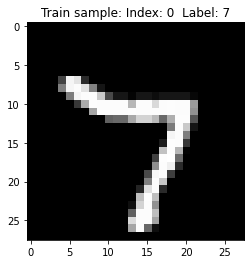

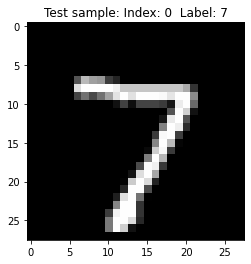

In [4]:
# Just a function to display a sample
def display_digit(index, xs, ys, title):
    label = np.argmax(ys[index]) # argmax used to convert from one-hot back to numeric label
    image = xs[index].reshape([28,28]) # make sure that the data is in 2D shape
    plt.title(title+': Index: %d  Label: %d' % (index, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

display_digit(index=0, xs=X_train, ys=y_train, title='Train sample') # display the first training example
display_digit(index=0, xs=X_test,  ys=y_test,  title='Test sample')  # display the first test example

That's right, the classes seem very easy to separate ! Let's prepare to train our algorithm.

## Define the model

We will build a neural network with a single layer:

* Use Kera's Dense to create a Fully Connected layer, use 'softmax' activation

![](./images/lr_diag.png "Logistic Regression")

In [5]:
# get input and output sizes
input_dim = X_train.shape[1] # 784
output_dim = y_train.shape[1] # 10

# Create Sequential model - this allows you to add layers one after the other to build your model
model = Sequential()
model.add(Dense(input_dim, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation='softmax'))


# Compile model
optim = SGD(lr=0.01)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

> **Note**: Be sure to rerun the previous cell before you train, otherwise previous weights will be kept - i.e. you would just train your model further.

In [6]:
# settings
batch_size = 64
nb_epoch = 50

# train the model and save training history
history = model.fit(X_train, y_train,
          batch_size=batch_size, 
          epochs=nb_epoch, 
          verbose=1, 
          validation_split=(0.06), # set 10K samples (out of 60K) aside for validation
)

# save model weights to file
model.save_weights('mnist_logistic_regression.h5')

Epoch 1/50
882/882 [==============================] - 1s 2ms/step - loss: 0.7709 - accuracy: 0.8167 - val_loss: 0.3623 - val_accuracy: 0.9014
Epoch 2/50
882/882 [==============================] - 1s 1ms/step - loss: 0.3411 - accuracy: 0.9062 - val_loss: 0.2802 - val_accuracy: 0.9178
Epoch 3/50
882/882 [==============================] - 1s 1ms/step - loss: 0.2848 - accuracy: 0.9202 - val_loss: 0.2451 - val_accuracy: 0.9297
Epoch 4/50
882/882 [==============================] - 1s 1ms/step - loss: 0.2520 - accuracy: 0.9291 - val_loss: 0.2202 - val_accuracy: 0.9367
Epoch 5/50
882/882 [==============================] - 1s 2ms/step - loss: 0.2278 - accuracy: 0.9365 - val_loss: 0.2012 - val_accuracy: 0.9453
Epoch 6/50
882/882 [==============================] - 1s 1ms/step - loss: 0.2078 - accuracy: 0.9421 - val_loss: 0.1914 - val_accuracy: 0.9478
Epoch 7/50
882/882 [==============================] - 1s 1ms/step - loss: 0.1913 - accuracy: 0.9466 - val_loss: 0.1754 - val_accuracy: 0.9517
Epoch 

## Plot training behaviour

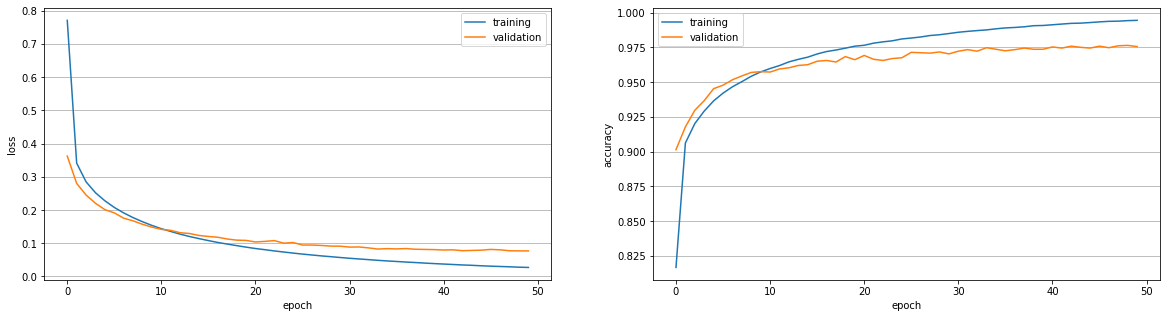

In [7]:
# summarize history for loss and accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['training', 'validation'], loc='upper right')
ax1.yaxis.grid()

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['training', 'validation'], loc='upper left')
ax2.yaxis.grid()

plt.show()

## Evaluate the model on the test set

In [8]:
# load model weights from file
model.load_weights('mnist_logistic_regression.h5')

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.07059241086244583
Test accuracy: 0.9789000153541565


You should have obtained a value of around 0.91-0.92 (which means 91%-92% test accuracy). Congratulations !

## Try the following

1) Change the learning rate (e.g. 0.0001, 0.001, 0.01, 0.1) and observe the training curves

2) Add Momentum to the SGD optimizer (https://keras.io/optimizers/) and observe the accuracy

3) Change the batch size (e.g. 8, 16, 32, 64, 128, 256) and see what happens (time per epoch, accuracy, etc)

4) Try a different optimizer altogether (e.g. Adam) (https://keras.io/optimizers/)

5) Try adding shuffling during training (https://keras.io/models/sequential/)

6) Share your best results !

In [9]:
#Test loss: 0.08374061435461044
#Test accuracy: 0.9757999777793884
    
#Test loss: 0.6157978177070618
#Test accuracy: 0.8604999780654907
    
#Test loss: 0.41158485412597656
#Test accuracy: 0.8931000232696533
    
#Test loss: 0.20520681142807007
#Test accuracy: 0.9416000247001648

#Test loss: 0.07649356126785278
#Test accuracy: 0.98580002784729
    
#Test loss: 0.06497085094451904
#Test accuracy: 0.9793999791145325


SyntaxError: invalid syntax (<ipython-input-9-084f3117fc68>, line 1)